# Machine Learning model to predict the price of a property in Colombia

### The aim of this model is to predict wether a property in Colombia is expensive based on the price mean. If the price is less than the mean, the property is categorized as cheap. Otherwise it's categorized as expensive.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
import seaborn as sns

First, the train data is imported using Pandas library. There's one file for the training set and one for the test set.

In [3]:
train_path = os.path.join(os.getcwd(),'data','properties_colombia_train.csv')

In [4]:
df_train = pd.read_csv(train_path)

The model will be supervised and the target value is the price of the property, so I keep just the rows with not null price values.

In [5]:
df_train.dropna(subset='price',inplace=True)

In [6]:
df_train.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


We can seee there are eight properties with USD currency.

In [7]:
df_train.groupby(df_train.currency).currency.count()

currency
COP    197474
USD         8
Name: currency, dtype: int64

The USD prices are converted to COP using the mean value extract from the following web page.

https://freecurrencyrates.com/es/exchange-rate-history/USD-COP/2020/yahoo

In [8]:
df_train.price = np.where(df_train.currency == 'USD', df_train.price*4000 , df_train.price)

In [9]:
df_train.drop('currency',axis=1,inplace=True)

The price mean is calculated in order to know the value separating the two categories.

In [10]:
price_mean = df_train.price.mean()
print(price_mean)

645315583.7466555


Using geopandas we can check if the locations correspond to a place in Colombia as it should be.

In [11]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

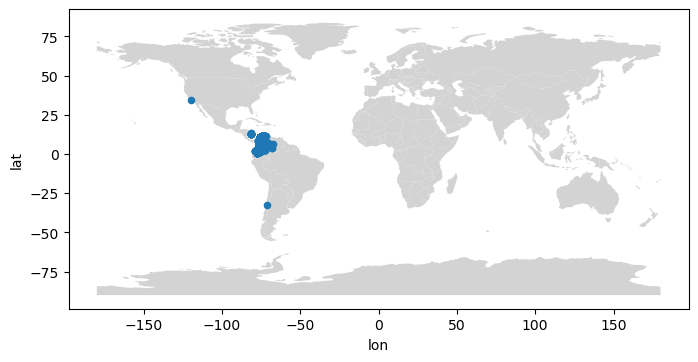

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey",ax=ax)

df_train.plot(x="lon", y="lat", kind="scatter",ax=ax)

plt.show()

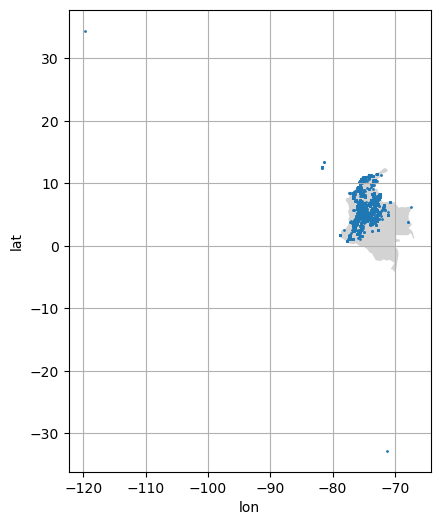

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

countries[countries["name"] == "Colombia"].plot(color="lightgrey",ax=ax)

df_train.plot(x="lon", y="lat", kind="scatter",ax=ax,s=1)

ax.grid(alpha=1)

plt.show()

Some of the dots outside Colombia are located in 'San Andrés Providencia y Santa Catalina' so I keep those:

In [14]:
df_train[(df_train.lat > 10)&(df_train.lat <20)&(df_train.lon>-90)&(df_train.lon<-80)].l2.unique()

array(['San Andrés Providencia y Santa Catalina'], dtype=object)

The following data is not correct. The lonigutudes and latitudes do not correspond to Cudinamarca.

In [15]:
df_train[(df_train.lat>30)|(df_train.lat<-30)]

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,bathrooms,surface_total,surface_covered,price,price_period,title,description,property_type,operation_type,geometry
138682,172722,0xtrMhsbAsQiEv9XHGWTIQ==,Propiedad,2020-09-29,2021-07-26,2020-09-29,-32.787342,-71.20732,Colombia,Cundinamarca,...,6.0,NaN,NaN,2.000000e+09,NaN,51548 LA CALERA MIRADO DEL LAGO,"Casa hermosa,amplia, vigilancia sector&nbsp; t...",Casa,Venta,POINT (-71.20732 -32.787342)
148562,819292,s6bCv2RXRdHQGyS2+7WZ8Q==,Propiedad,2020-11-06,2021-07-26,2020-11-06,34.420334,-119.69819,Colombia,Cundinamarca,...,4.0,NaN,NaN,6.000000e+08,NaN,51599 SANTA BARBARA APARTAMENTO 506,"Apartamento&nbsp; para&nbsp; remodelar , duple...",Apartamento,Venta,POINT (-119.69819 34.420334)


In [16]:
df_train = df_train[(df_train.lat<30)&(df_train.lat>-30)]

The 'Unnamed', 'id', 'operation_type','price_period', 'start_date','end_date' and 'created_on' columns do not provide useful information.<br>
The 'geometry' column provides the same information as 'lat' and 'lon'.<br>
The 'l1', 'l2', 'l3, 'l4', l5' and 'l6' columns are also related to the geographical location.

In [17]:
print(df_train.price_period.unique())
print(df_train.operation_type.unique())
print(df_train.ad_type.unique())

[nan 'Mensual']
['Venta']
['Propiedad']


In [18]:
df_train.drop(['Unnamed: 0','id','geometry','l1','l2','l3','l4','l5','l6','operation_type','created_on','start_date','end_date','price_period','ad_type'],axis=1,inplace=True)

/var/folders/wh/7jr3ry9j3cb9x1sd3ncj65w40000gn/T/ipykernel_1722/3942336373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['Unnamed: 0','id','geometry','l1','l2','l3','l4','l5','l6','operation_type','created_on','start_date','end_date','price_period','ad_type'],axis=1,inplace=True)


The columns 'title' and 'description' won't be used in this analysis.

In [19]:
df_train.drop(['title','description'],axis=1,inplace=True)

/var/folders/wh/7jr3ry9j3cb9x1sd3ncj65w40000gn/T/ipykernel_1722/122552676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['title','description'],axis=1,inplace=True)


The categorical column property_type is not numerical so it should be encoded, otherwise the machine learning model won't work.


In [20]:
df_dummies = pd.get_dummies(df_train.property_type)
df_dummies.drop('Otro',axis=1,inplace=True)

In [21]:
df_train = df_train.join(df_dummies)
df_train.drop('property_type',axis=1,inplace=True)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147994 entries, 0 to 197548
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              147994 non-null  float64
 1   lon              147994 non-null  float64
 2   rooms            26951 non-null   float64
 3   bedrooms         37729 non-null   float64
 4   bathrooms        111147 non-null  float64
 5   surface_total    6476 non-null    float64
 6   surface_covered  9175 non-null    float64
 7   price            147994 non-null  float64
 8   Apartamento      147994 non-null  uint8  
 9   Casa             147994 non-null  uint8  
 10  Finca            147994 non-null  uint8  
 11  Local comercial  147994 non-null  uint8  
 12  Lote             147994 non-null  uint8  
 13  Oficina          147994 non-null  uint8  
 14  Parqueadero      147994 non-null  uint8  
dtypes: float64(8), uint8(7)
memory usage: 15.2 MB


Using the matrix correlation we can check if there are redundant variables.

In [23]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Apartamento,Casa,Finca,Local comercial,Lote,Oficina,Parqueadero
lat,1.000000,0.355364,-0.089757,-0.087846,-0.078595,-0.015002,-0.002081,-0.004473,0.068248,-0.028729,-0.026257,-0.018112,-0.009089,-0.015274,0.002155
lon,0.355364,1.000000,-0.095596,-0.058126,-0.031726,0.008482,-0.005963,0.031944,-0.002129,0.028028,-0.034198,0.002719,-0.013588,0.029157,0.004141
rooms,-0.089757,-0.095596,1.000000,0.999119,0.660452,0.084204,0.048296,0.174028,-0.424522,0.307650,0.121515,-0.011758,-0.005130,-0.024329,0.003503
bedrooms,-0.087846,-0.058126,0.999119,1.000000,0.592654,0.068549,0.043320,0.084875,-0.341072,0.321361,0.094060,-0.090141,-0.123171,-0.097596,-0.006604
bathrooms,-0.078595,-0.031726,0.660452,0.592654,1.000000,0.104650,0.052947,0.328040,-0.314651,0.271987,0.021963,-0.023045,-0.003202,-0.043423,nan
surface_total,-0.015002,0.008482,0.084204,0.068549,0.104650,1.000000,0.693971,0.302464,-0.157288,-0.034804,0.280226,-0.027444,0.264033,-0.033116,-0.001716
surface_covered,-0.002081,-0.005963,0.048296,0.043320,0.052947,0.693971,1.000000,0.148000,-0.025060,-0.009422,0.104063,-0.003255,0.033310,-0.004177,-0.000038
price,-0.004473,0.031944,0.174028,0.084875,0.328040,0.302464,0.148000,1.000000,-0.110520,-0.021257,0.020765,0.028466,0.118082,0.006455,-0.000309
Apartamento,0.068248,-0.002129,-0.424522,-0.341072,-0.314651,-0.157288,-0.025060,-0.110520,1.000000,-0.662691,-0.082304,-0.085219,-0.291713,-0.078746,-0.006933
Casa,-0.028729,0.028028,0.307650,0.321361,0.271987,-0.034804,-0.009422,-0.021257,-0.662691,1.000000,-0.061344,-0.063516,-0.217422,-0.058692,-0.005167


Rooms and bedrooms are highly correlated so I use rooms data to fill the bedrooms missing information.

In [24]:
df_train.bedrooms.fillna(df_train.rooms,inplace=True)

In [25]:
df_train.drop('rooms',axis=1,inplace=True)

We can use the bedrooms data to predict the missing values in bathrooms.

In [26]:
df_regression = pd.concat([df_train.bathrooms,df_train.bedrooms],axis=1)

In [27]:
df_regression.dropna(inplace=True)

In [28]:
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18735 entries, 0 to 197542
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bathrooms  18735 non-null  float64
 1   bedrooms   18735 non-null  float64
dtypes: float64(2)
memory usage: 439.1 KB


#### Regression Model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X=df_regression.bedrooms.values.reshape(-1,1)
y=df_regression.bathrooms.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

R-scored

In [30]:
model.score(X_test,y_test)

0.35368697858638987

R-scored with coss-validation

In [31]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)
reg = LinearRegression()
cv_results = cross_val_score(reg, X, y, cv=kf)

In [32]:
print(np.mean(cv_results), np.std(cv_results))

0.34947741160763934 0.031738218525375436


In [33]:
print(np.quantile(cv_results, [0.025, 0.975]))

[0.31107762 0.4019719 ]


Model parameters

In [34]:
print(model.coef_[0])
print(model.intercept_)

0.5253806490470895
1.0875902937526012


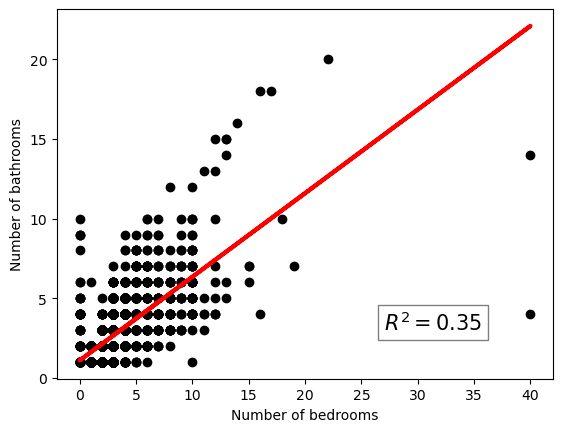

In [35]:
y_pred = model.predict(X_test)
plt.text(27, 3, '$R^2 = 0.35$', fontsize = 15, bbox = dict(facecolor = 'white', alpha = 0.5))
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="red", linewidth=3)
plt.xlabel('Number of bedrooms')
plt.ylabel('Number of bathrooms')
plt.show()

Now I apply this model to predict the missing data in bathrooms.

In [36]:
df_train.bathrooms.fillna(df_train.bedrooms*model.coef_[0]+model.intercept_,inplace=True)

In [37]:
df_train.drop('bedrooms',axis=1,inplace=True)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147994 entries, 0 to 197548
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              147994 non-null  float64
 1   lon              147994 non-null  float64
 2   bathrooms        130212 non-null  float64
 3   surface_total    6476 non-null    float64
 4   surface_covered  9175 non-null    float64
 5   price            147994 non-null  float64
 6   Apartamento      147994 non-null  uint8  
 7   Casa             147994 non-null  uint8  
 8   Finca            147994 non-null  uint8  
 9   Local comercial  147994 non-null  uint8  
 10  Lote             147994 non-null  uint8  
 11  Oficina          147994 non-null  uint8  
 12  Parqueadero      147994 non-null  uint8  
dtypes: float64(6), uint8(7)
memory usage: 12.9 MB


The columns 'surface_total' and 'surface_covered' have too many missing values.

In [39]:
df_train.drop(['surface_total','surface_covered'],axis=1,inplace=True)

In [40]:
df_train.dropna(inplace=True)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130212 entries, 0 to 197548
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              130212 non-null  float64
 1   lon              130212 non-null  float64
 2   bathrooms        130212 non-null  float64
 3   price            130212 non-null  float64
 4   Apartamento      130212 non-null  uint8  
 5   Casa             130212 non-null  uint8  
 6   Finca            130212 non-null  uint8  
 7   Local comercial  130212 non-null  uint8  
 8   Lote             130212 non-null  uint8  
 9   Oficina          130212 non-null  uint8  
 10  Parqueadero      130212 non-null  uint8  
dtypes: float64(4), uint8(7)
memory usage: 5.8 MB


Finally, I convert the price column because the model has to predict wether a property is cheap (0) or expensive (1). This column will be the target while the rest are the features.

In [42]:
df_train.price = df_train.price.apply(lambda x: 0 if x < price_mean else 1)

In [75]:
y_train = df_train.price.values                 ##target
X_train = df_train.drop('price',axis=1).values  ##features

We also need to preprocess the test data. It should have the same amount of columns as the number of features.

In [81]:
test_path = os.path.join(os.getcwd(),'data','properties_colombia_test.csv')
df_test = pd.read_csv(test_path)

In [82]:
df_test.drop(['Unnamed: 0','id','geometry','l1','l2','l3','l4','l5','l6','operation_type','created_on','start_date','end_date','price_period','ad_type','title','description','surface_total','surface_covered','currency'],axis=1,inplace=True)

In [83]:
df_dummies = pd.get_dummies(df_test.property_type)
df_dummies.drop('Otro',axis=1,inplace=True)
df_test = df_test.join(df_dummies)
df_test.drop('property_type',axis=1,inplace=True)

In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              49433 non-null  float64
 1   lon              49433 non-null  float64
 2   rooms            9110 non-null   float64
 3   bedrooms         13403 non-null  float64
 4   bathrooms        52054 non-null  float64
 5   Apartamento      65850 non-null  uint8  
 6   Casa             65850 non-null  uint8  
 7   Finca            65850 non-null  uint8  
 8   Local comercial  65850 non-null  uint8  
 9   Lote             65850 non-null  uint8  
 10  Oficina          65850 non-null  uint8  
 11  Parqueadero      65850 non-null  uint8  
dtypes: float64(5), uint8(7)
memory usage: 3.0 MB


In [85]:
df_test.drop(['rooms','bedrooms'],axis=1,inplace=True)

In [90]:
df_test.dropna(inplace=True)

In [91]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37074 entries, 0 to 65848
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              37074 non-null  float64
 1   lon              37074 non-null  float64
 2   bathrooms        37074 non-null  float64
 3   Apartamento      37074 non-null  uint8  
 4   Casa             37074 non-null  uint8  
 5   Finca            37074 non-null  uint8  
 6   Local comercial  37074 non-null  uint8  
 7   Lote             37074 non-null  uint8  
 8   Oficina          37074 non-null  uint8  
 9   Parqueadero      37074 non-null  uint8  
dtypes: float64(3), uint8(7)
memory usage: 1.4 MB


In [93]:
X_test = df_test.values    ## test features

### KNN Model

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [88]:
print(X_train.shape,y_train.shape)

(130212, 10) (130212,)


In [77]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [94]:
y_pred = knn.predict(X_test)

In [98]:
pred = pd.DataFrame(data=y_pred,columns=['pred'])

In [100]:
pred.to_csv(os.path.join(os.getcwd(),'data','julicaro31.csv'),index=False)